In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from random import shuffle
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, \
    Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Multiply, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import NASNetMobile, preprocess_input
from keras.optimizers import Adam
from imgaug import augmenters as iaa
import imgaug as ia

Using TensorFlow backend.


In [2]:
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1].replace('.tif', '')
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [3]:
test_files = glob('/home/neha/Documents/Cancer Detection/test_img/*.tif')
print("test_files size :", len(test_files))

test_files size : 30


In [4]:
batch_size = 5

In [5]:
def get_model_classif_nasnet():
    inputs = Input((96, 96, 3))
    base_model = NASNetMobile(include_top = False, input_shape=(96, 96, 3), weights=None)
    x = base_model(inputs)
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    out = Dense(1, activation="sigmoid", name="3_")(out)
    model = Model(inputs, out)
    model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
    model.summary()

    return model

In [6]:
model = get_model_classif_nasnet()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 1056)   4269716     input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1056)         0           NASNet[1][0]                     
____________________________________________________________________________________________

In [7]:
h5_path = "/home/neha/Documents/Cancer Detection/model.h5"

In [8]:
model.load_weights(h5_path)

In [9]:
batchNo = 5 # maximum batch number 30/5=6. So range - 0 to 5
ba = list(chunker(test_files, batch_size))[batchNo]
X = [preprocess_input(cv2.imread(x)) for x in ba]
X = np.array(X)
pred = (model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel()**0.25).tolist()

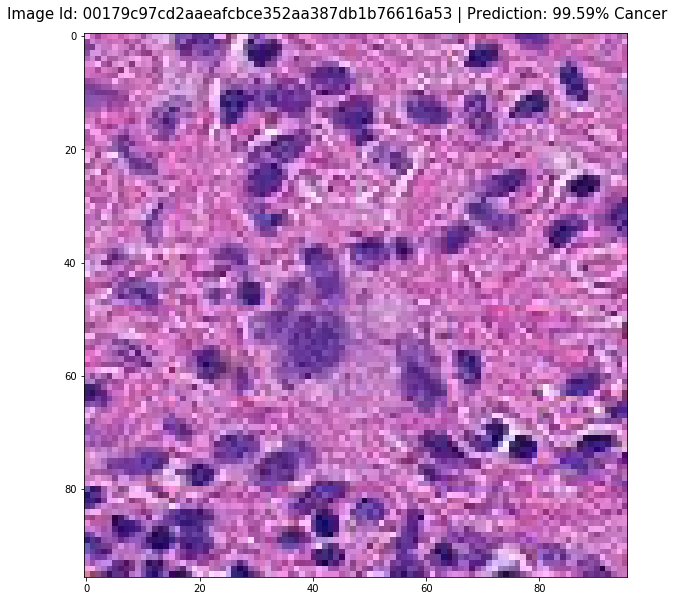

In [17]:
# for i in range(5):
i = 2
fig = plt.figure(figsize=(20,10))
img = plt.imread(ba[i])
label = "Image Id: " + get_id_from_file_path(ba[i]) + " | Prediction: " + str(pred[i]*100)[:5] + "% Cancer"
plt.figtext(.5,.9,label, fontsize=15, ha='center')
plt.imshow(img)